## Color Selection (Testing with basic image with clearly defined solid whites)

In [58]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# for getting img from video_images for video
import glob
from PIL import Image
import io

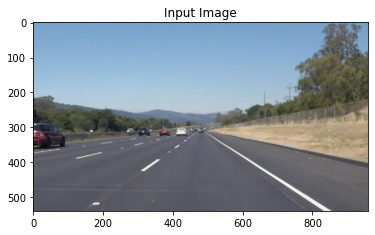

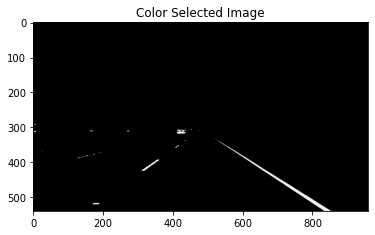

In [59]:
# Read in the image
img = mpimg.imread('./basic_tests/solidWhiteRight.jpg')

# Grab the x and y size and make a copy of the image
ysize, xsize = img.shape[0], img.shape[1]
img_copy = np.copy(img)

# color selection criteria
r_thres, g_thres, b_thres = 210,210,210
#rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Do a boolean or with the "|" character to identify
# pixels below the thresholds
rgb_thres = (img[:,:,0] < r_thres) \
            | (img[:,:,1] < g_thres) \
            | (img[:,:,2] < b_thres)
img_copy[rgb_thres] = [0,0,0]

# Display the image
plt.imshow(img)
plt.title("Input Image")
plt.show()
plt.imshow(img_copy)
plt.title("Color Selected Image")
plt.show()

## Region Masking

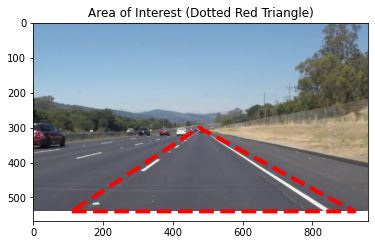

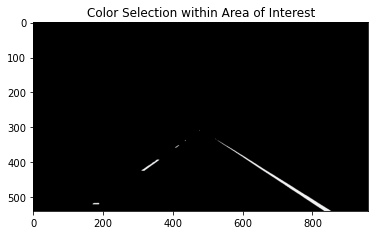

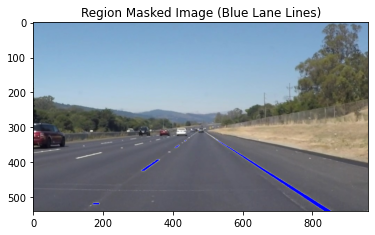

In [60]:
# Read in the image
img = mpimg.imread('./basic_tests/solidWhiteRight.jpg')

# grab dimensions & make copy
ysize, xsize = img.shape[0], img.shape[1]
img_copy = np.copy(img)
img_copy2 = np.copy(img)

# color selection criteria
r_thres, g_thres, b_thres = 210,210,210

# rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define mask region (triangle)
left_bottom = [110, 540]
right_bottom = [920, 540]
top = [475, 300]

# Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
# np.polyfit returns the coefficients [A, B] of the fit
l_fit = np.polyfit((left_bottom[0], top[0]), (left_bottom[1], top[1]), 1)
r_fit = np.polyfit((right_bottom[0], top[0]), (right_bottom[1], top[1]), 1)
b_fit = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Mask pixels below the threshold
color_thresholds = (img[:,:,0] < r_thres) | \
                    (img[:,:,1] < g_thres) | \
                    (img[:,:,2] < b_thres)

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*l_fit[0] + l_fit[1])) & \
                    (YY > (XX*r_fit[0] + r_fit[1])) & \
                    (YY < (XX*b_fit[0] + b_fit[1]))
                    
# Mask color and region selection
img_copy[color_thresholds | ~region_thresholds] = [0, 0, 0]
# Color pixels red where both color and region selections met
img_copy2[~color_thresholds & region_thresholds] = [0, 0, 255]

# Display the image and show region and color selections
plt.imshow(img)
x = [left_bottom[0], right_bottom[0], top[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], top[1], left_bottom[1]]
plt.plot(x, y, 'r--', lw=4)
plt.title("Area of Interest (Dotted Red Triangle)")
plt.show()
plt.imshow(img_copy)
plt.title("Color Selection within Area of Interest")
plt.show()
plt.imshow(img_copy2)
plt.title("Region Masked Image (Blue Lane Lines)")
plt.show()

## Adding Canny Edge to Better Detect Yellow Lanes and other Obscure Colors

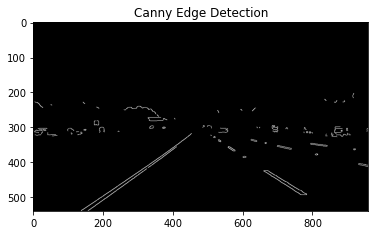

In [61]:
# Do all the relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read image & convert to grayscale
img = mpimg.imread('./basic_tests/solidYellowLeft.jpg')
gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

# kernel size = 5
gray_blurring = cv2.GaussianBlur(gray_img,(5, 5),0)

# Define our parameters for Canny and run it
#low_threshold = 180
#high_threshold = 240
edges = cv2.Canny(gray_blurring, 180, 240)

# Display the image
plt.imshow(edges, cmap='Greys_r')
plt.title("Canny Edge Detection")
plt.show()

## Hough Transform

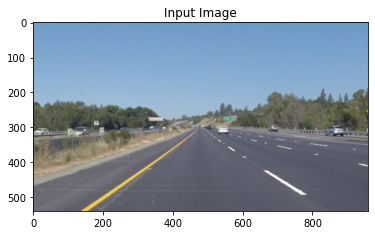

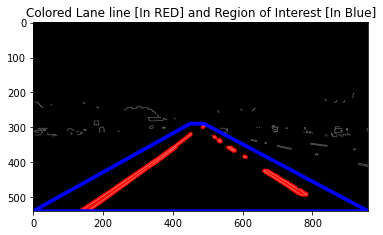

In [62]:
# Read image & convert to grayscale
img = mpimg.imread('./basic_tests/solidYellowLeft.jpg')
gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

# kernel_size = 5
gray_blurring = cv2.GaussianBlur(gray_img,(5, 5),0)

# Define our parameters for Canny and apply
#low_threshold = 180
#high_threshold = 240
edges = cv2.Canny(gray_blurring, 180, 240)

#create masked edge image
mask = np.zeros_like(edges)
ignore_mask_color = 255

# This time we are defining a four sided polygon to mask
imshape = img.shape
vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, 255)
masked_edges = cv2.bitwise_and(edges, mask)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 2     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 4 #minimum number of pixels making up a line
max_line_gap = 5    # maximum gap in pixels between connectable line segments
line_image = np.copy(img)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
lines_edges = cv2.polylines(lines_edges,vertices, True, (0,0,255), 10)
plt.imshow(img)
plt.title("Input Image")
plt.show()
plt.imshow(lines_edges)
plt.title("Colored Lane line [In RED] and Region of Interest [In Blue]")
plt.show()

In [93]:
def extractROI(img, points):
    """
    Helper function to extract region of interest and mask other parts of image 
    """
    mask = np.zeros_like(img)   
    
    # fill the mask
    if len(img.shape) <= 2: # one color
        cv2.fillPoly(mask, points, ignore_mask_color)
    else: # multiple color channels
        cv2.fillPoly(mask, points, (255,) * img.shape[2])

    # ingnore non masked regions
    return cv2.bitwise_and(img, mask)

def drawLines(img, lines):
    img = img.copy()
    # order = [0,1,3,2]
    #print("LINES: ", lines)
    left = []
    right = []
    
    for l in lines:
        for x1,y1,x2,y2 in l:
            if x1 != x2:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1
                if m >= 0:
                    right.append((m,c))
                else:
                    left.append((m,c))
    #print("LEFT: ", left)
    #print("RIGHT: ", right)                
    line_l = np.mean(left, axis=0)
    line_r = np.mean(right, axis=0)
    
    line = [line_l, line_r]
    vertices = []
    #print("LINE:", line)
    for s, i in line:
        r, _ = img.shape[:2] #f'./basic_tests/{image_path}'
        y1 = int(r)
        x1 = int((y1-i)/s)
        y2 = int(r*0.60) #0.58
        x2 = int((y2-i)/s)
        
        vertices.append((x1, y1))
        vertices.append((x2, y2))
        
        # draw_lines(img, np.array([[[x1,y1,x2,y2]]]))
        l2 = np.array([[[x1,y1,x2,y2]]]) 
        for line in l2:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), [255,255,0], 10)
    vertices = [vertices[i] for i in [0,1,3,2]]
        
    points = np.array([vertices],'int32')
    c = (0,255,0)
    cv2.fillPoly(img, points, c)
    
    return cv2.addWeighted(img,0.9,img,0.5,0)

def computeHoughLines(img, rho, theta, threshold, minLineLength, maxLineGap):
    # compute hough lines
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength, maxLineGap)
    # draw lines on image
    out_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8) 
    return drawLines(out_img,lines)
    # return line_img


In [91]:
def findLanes(image):
    # grab region of interest
    R,C = image.shape[:2]
    b_l, t_l, b_r, t_r  = (C*0.15, R), (C*0.45, R*0.6), (C*0.95, R), (C*0.55, R*0.6) #[C*0.15, R], [C*0.45, R*0.6], [C*0.95, R], [C*0.55, R*0.6] 
    pts_raw = [b_l, t_l, b_r, t_r]
    pts = np.array([pts_raw],dtype = np.int64)
    
    #convert image to gray scale
    img = image
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Apply gaussian smoothing
    smoothed_img = cv2.GaussianBlur(img, (5, 5), 0)
    #plt.imshow(smoothed_img)
    # Perform canny edge detection
    canny_img = cv2.Canny(smoothed_img, 20, 80)
    #plt.imshow(canny_img)
    #return canny_img
    # mask the image within target region
    masked_img = extractROI(canny_img, pts)
    # Perform Hough Transform\
    rho, theta = 1, np.pi/90
    thres = 15
    minLL, maxLG = 20, 160
    houghed_lines = computeHoughLines(masked_img, rho, theta, thres, minLL, maxLG)
    #Draw lines over 
    return cv2.addWeighted(image, 0.9, houghed_lines, 1., 0.)


## Current Approach on simple dataset

In [ ]:
for image_path in list(os.listdir('./basic_tests')): #  list(os.listdir('./Dataset-3/Day-Time/minitestday'))[:-1]: # add test images
    fig = plt.figure(figsize=(20, 10))
    # image = mpimg.imread(f'./Dataset-3/Day-Time/minitestday/{image_path}')
    # read in image and convert image to 8 bit integers
    image = mpimg.imread(f'./basic_tests/{image_path}')
    image = image.astype(np.float64)
    #image = image * 255
    image = image.astype(np.uint8)
    #print(image.dtype)
    ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("Input")
    ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
    plt.imshow(findLanes(image))
    ax.set_title("Output")
    plt.show()

## Current Approach on bad dataset

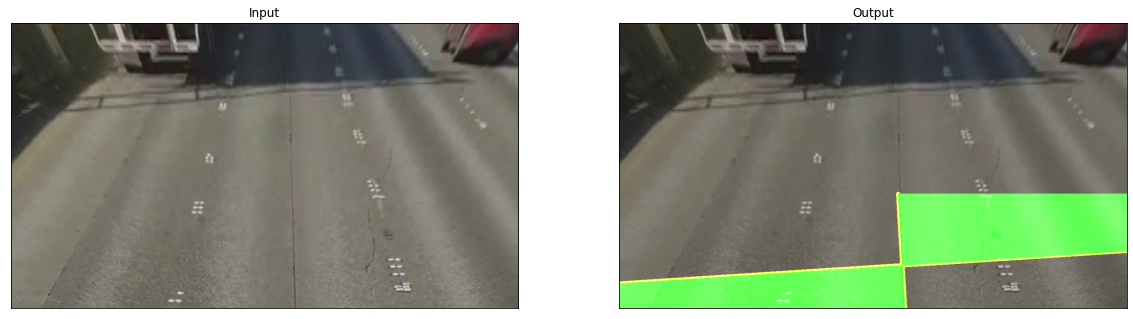

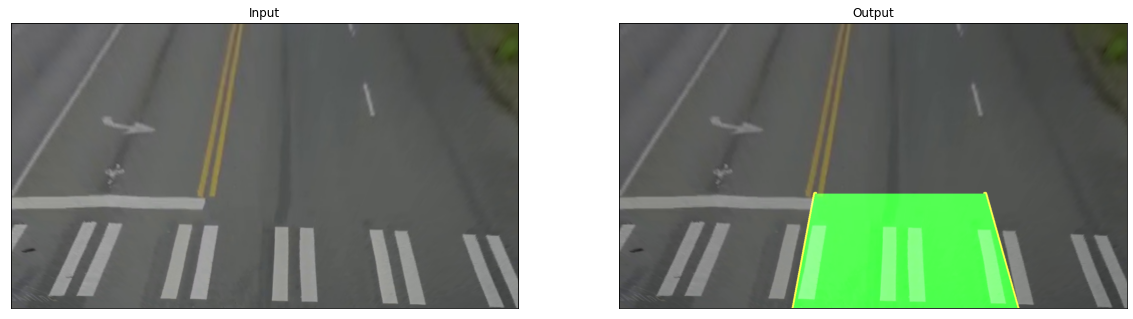

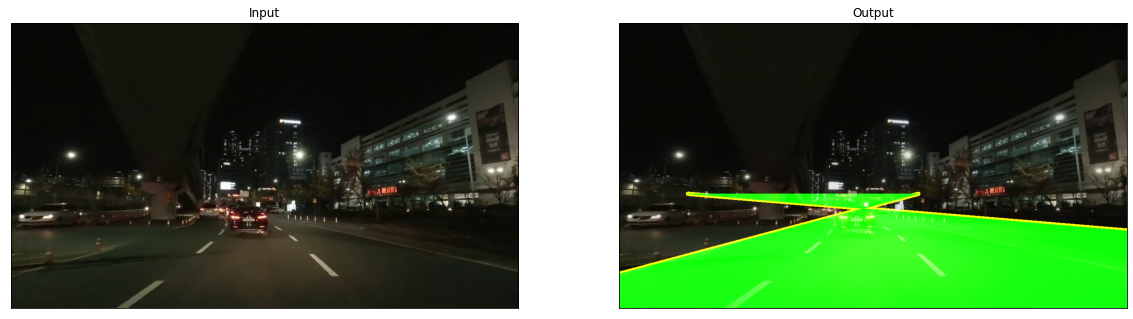

In [102]:
count = 0
for image_path in list(os.listdir('./Failed_test')):
    fig = plt.figure(figsize=(20, 10))
    image = mpimg.imread(f'./Failed_test/{image_path}')
    #plt.imshow(image)
    image = image.astype(np.float64)
    image*=255
    image = image.astype(np.uint8)
    ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("Input")
    ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
    new_img = findLanes(image)
    plt.imshow(new_img)
    cv2.imwrite("./Failed_annotated_image/image%d.jpg" % count, new_img)
    count+=1
    ax.set_title("Output")
    plt.show()

## Testing on video

In [18]:
cap = cv2.VideoCapture('./basic_vid_test/testvid.mp4')
window_shape = (1280,720)
output = cv2.VideoWriter('./basic_vid_test/testout.mp4', cv2.VideoWriter_fourcc('M','J','P','G'), 20, window_shape)

success,image = cap.read()
count = 0
while success:
    cv2.imwrite("./video_images/image%d.jpg" % count, image)
    success,image = cap.read()
    count += 1

file_list = list(os.listdir('./video_images'))
for i in range(len(file_list)):
    # read in image and convert image to 8 bit integers
    image_path = 'image' + str(i) + '.jpg'
    image = mpimg.imread(f'./video_images/{image_path}')
    cv2.imwrite("./v_i_a/" + image_path, findLanes(image))

image_folder = 'v_i_a'
video_name = 'video2.avi'
images = []
for i in range(len(file_list)):
    img = 'image' + str(i) + '.jpg'
    images.append(img)

#images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 30, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
